<font face='Tahoma' size = 2.5>Problem Overview : <br>
 The goal of this project is to extend the classical newsvendor model in a few ways to make a better approximation of
reality.
<br><br>
In our first extension, we will assume that if you don’t print enough newspapers to satisfy demand, then
you can send a rush order to the printers to print all that you need.
    
<br> These rushed newspapers cost more to print, we will call the cost per rushed newspaper g, where g>c. Additionally, if you print more than the demand you must pay a disposal fee of t dollars per newspaper. 
    
<br> You could alternatively think about this as receiving money for taking excess newspapers to a recycling center if t\<0, but for now we’ll think of t>0. Putting this together, the objective function is:

In [292]:
import numpy as np
import gurobipy as gp
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import copy
warnings.filterwarnings("ignore")
%matplotlib inline

In [293]:
demand_df = pd.read_csv('price_demand_data.csv')

<font face='Tahoma' size = 2.5>
Number of days have the data for :

In [294]:
nd = demand_df.shape[0] # number of days of demand data
nd

99

<font face='Tahoma' size = 2.5>
We see price for each day is variable

In [295]:
demand_df.head()

,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002


<font face='Tahoma' size = 2.5>
Regressing demand against price to check for any trends :

In [296]:
X = demand_df.price # independent variable
y = demand_df.demand   # dependent variable
X = sm.add_constant(X)
ols = sm.OLS(y,X).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     159.3
Date:                Mon, 21 Feb 2022   Prob (F-statistic):           3.51e-22
Time:                        17:49:19   Log-Likelihood:                -636.17
No. Observations:                  99   AIC:                             1276.
Df Residuals:                      97   BIC:                             1282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1924.7175    111.334     17.288      0.0

<font face='Tahoma' size = 2.5>We observe the following -
* Demand has decent correlation with price resulting in an R-square of 0.62
* Both the intercept and price co-efficients are statistically significant
* Demand varies inversely with price which makes intuitive sense

<font face='Tahoma' size = 2.5> **Approach 1 - Assume error model to generate data**

<font face='Tahoma' size = 2.5> Assuming price = 1 and that each day the error could be from a distribution of $N(\mu,\sigma)$ from the regression above, let's simulate the demand from the linear regression residuals. The residuals are assumed to follow the normal distribution as below 

In [270]:
err_mean = np.mean(ols.resid)
err_var = np.std(ols.resid)
resid = stats.shapiro(ols.resid)
print ('N (',round(err_mean,4),' , ',round(err_var,4),')')

N ( 0.0  ,  149.452 )


<font face='Tahoma' size = 2.5> The Shapiro Wilk test for Normality validates the normal distribution of the residuals given it rejects the null hypothesis for normality with a p-value as below -

In [271]:
round(resid.pvalue,4)

0.2565

<font face='Tahoma' size = 2.5> We can simulate data using the mean and variables of the error model

In [272]:
#Generate data
dem_sim = copy.deepcopy(demand_df)
dem_sim['price'] = 1
dem_sim['demand'] = ols.predict(pd.DataFrame([1]*99 , dem_sim['price'].values,columns=['price']).reset_index())
np.random.seed(1)
dem_sim['err'] = np.random.normal(loc=err_mean , scale = err_var, size = dem_sim.shape[0])
dem_sim['demand'] = dem_sim['demand'] + dem_sim['err']

<font face='Tahoma' size = 2.5> Simulated demand looks like -

<AxesSubplot:>

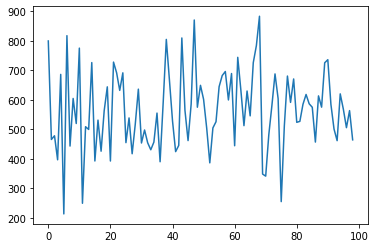

In [273]:
dem_sim['demand'].plot()

<font face='Tahoma' size = 2.5>
Setting the cost, cost for rush order (g) and disposal costs (t) and working with p = 1 (assumption) scenario :

In [274]:
cost = 0.5
g = 0.75
t = 0.15
p = dem_sim['price'][0]

In [275]:
nd = demand_df.shape[0] # number of days of demand data
nd

99

<font face='Tahoma' size = 2.5>
The new objective function, as per SAA (Sample Average Approximation) would be :
    $$max_q\frac{1}{n} \sum\limits_{i=1}^{n}p_iD_i -qc - g(D_i-q)^{+} - t(q-D_i)^{+}$$
    
where $q$ is quantity of newspapers as a decision variable <br>
    $n$ is number of samples available with past demand <br>
    $c$ is cost without rush order <br>
    $g$ is higher cost to match upto the demand <br>
    $t$ is disposal cost to enable disposal/recycle <br>
    
and the terms  $g(D_i-q)^{+}$ and $t(q-D_i)^{+}$ indicate if the quantity in the braces is positive in value. It'll be interesting to convert this into a linear programming problem.
    
<br>



<font face='Tahoma' size = 2.5>
We use expected profit as the objective function. Say we define $h_i$ as profit on $i^{th}$ day. Given our assumption that next day's profit is from the distribution of historical demand, we use all datapoints for SAA to evaluate expected profit.

<font face='Tahoma' size = 2.5>
We formulate the constraints of the problem as follows :
    $$h_i \leq p_iD_i - qc - g(D_i - q)\;\;\;\;\;\;\; \forall (q < D_i) $$
    $$h_i \leq p_iD_i - qc - t(q - D_i)\;\;\;\;\;\;\; \forall (q \geq D_i) $$
    
to convert this into an LPP and objective function becomes an average of the $h_i$'s

In [276]:
# decision variables are (q, h1, h2, ..., h25)
obj = np.zeros(nd+1)
obj[1:] = 1.0/nd

#Set respective lower bounds
lb = np.zeros(nd+1)
lb[1:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative

#RHS and directionality of constraints
rhs = np.zeros(2*nd)
direction = np.array(['<']*(2*nd))

<font face='Tahoma' size = 2.5>Constraints for the problem are :
$$h_i \leq (g - c)q + (p_i-g)D_i $$
$$h_i \leq  -(c+t)q + (p_i+t)D_i$$
<br>


In [277]:
A = np.zeros((2*nd,nd+1))
for r in range(nd):
    A[2*r,[0,r+1]] = [cost+t,1] 
    rhs[2*r] = (dem_sim['price'][r] + t ) * dem_sim.demand[r]
    A[2*r+1,[0,r+1]] = [cost-g,1]
    rhs[2*r+1] = (dem_sim['price'][r] - g ) * dem_sim.demand[r]


<font face='Tahoma' size = 2.5>Constraints for the problem are written as input to Gurobi :

In [278]:
for i in range(3):
    print(A[i] , direction[i] , rhs[i], "\n\n")

[0.65 1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.  ] < 919.731611842354 


[-0.25  1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0

In [279]:
#Gurobi run - lpp
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb) 
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs)
spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)
spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()

<font face='Tahoma' size = 2.5> Decision variables, the first one being quantity q are as follows :

In [280]:
#Decision variables
[round(x,4) for x in spMod_x.x[0:10]]

[481.6116,
 320.3446,
 222.3658,
 236.7315,
 143.0974,
 291.9884,
 -68.0567,
 324.8455,
 196.6798,
 271.5744]

<font face='Tahoma' size = 2.5> Optimal value from the optimization :

In [281]:
round(spMod.objval,4)

243.4894

<font face='Tahoma' size = 2.5>On each day, how many newspapers did we actually sell

In [282]:
numsold = np.minimum(spMod_x.x[0],dem_sim.demand) 
numsold

0     481.611607
1     465.576824
2     478.068715
3     396.647755
4     481.611607
         ...    
94    481.611607
95    481.611607
96    481.611607
97    481.611607
98    464.344678
Name: demand, Length: 99, dtype: float64

<font face='Tahoma' size = 2.5> **Approach 2 - Assume error remained same historically**

<font face='Tahoma' size = 2.5> We extract the error component of each historical day and assume it to be constant for that particular day.

In [309]:
#Generate data
dem_sim = copy.deepcopy(demand_df)
dem_sim['price'] = 1
dem_sim['demand'] = ols.predict(pd.DataFrame([1]*99 , dem_sim['price'].values,columns=['price']).reset_index())
np.random.seed(1)
dem_sim['err'] = demand_df.demand - ols.params[1]*demand_df.price - ols.params[0]
#np.std(demand_df.demand - ols.params[1]*demand_df.price - ols.params[0])

In [310]:
#simulated demand
dem_sim['demand'] = dem_sim['demand'] + dem_sim['err']

<font face='Tahoma' size = 2.5> Simulated demand looks like -

<AxesSubplot:>

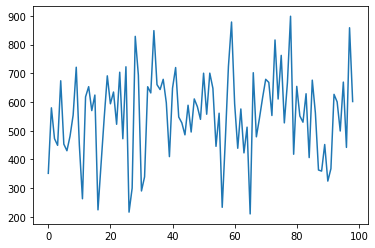

In [311]:
dem_sim['demand'].plot()

<font face='Tahoma' size = 2.5>
Setting the cost, cost for rush order (g) and disposal costs (t) and working with p = 1 (assumption) scenario :

In [312]:
cost = 0.5
g = 0.75
t = 0.15
p = dem_sim['price'][0]

In [313]:
nd = demand_df.shape[0] # number of days of demand data
nd

99

<font face='Tahoma' size = 2.5>
The new objective function, as per SAA (Sample Average Approximation) would be :
    $$max_q\frac{1}{n} \sum\limits_{i=1}^{n}p_iD_i -qc - g(D_i-q)^{+} - t(q-D_i)^{+}$$
    
where $q$ is quantity of newspapers as a decision variable <br>
    $n$ is number of samples available with past demand <br>
    $c$ is cost without rush order <br>
    $g$ is higher cost to match upto the demand <br>
    $t$ is disposal cost to enable disposal/recycle <br>
    
and the terms  $g(D_i-q)^{+}$ and $t(q-D_i)^{+}$ indicate if the quantity in the braces is positive in value. It'll be interesting to convert this into a linear programming problem.
    
<br>



<font face='Tahoma' size = 2.5>
We use expected profit as the objective function. Say we define $h_i$ as profit on $i^{th}$ day. Given our assumption that next day's profit is from the distribution of historical demand, we use all datapoints for SAA to evaluate expected profit.

<font face='Tahoma' size = 2.5>
We formulate the constraints of the problem as follows :
    $$h_i \leq p_iD_i - qc - g(D_i - q)\;\;\;\;\;\;\; \forall (q < D_i) $$
    $$h_i \leq p_iD_i - qc - t(q - D_i)\;\;\;\;\;\;\; \forall (q \geq D_i) $$
    
to convert this into an LPP and objective function becomes an average of the $h_i$'s

In [314]:
# decision variables are (q, h1, h2, ..., h25)
obj = np.zeros(nd+1)
obj[1:] = 1.0/nd

#Set respective lower bounds
lb = np.zeros(nd+1)
lb[1:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative

#RHS and directionality of constraints
rhs = np.zeros(2*nd)
direction = np.array(['<']*(2*nd))

<font face='Tahoma' size = 2.5>Constraints for the problem are :
$$h_i \leq (g - c)q + (p_i-g)D_i $$
$$h_i \leq  -(c+t)q + (p_i+t)D_i$$
<br>


In [315]:
A = np.zeros((2*nd,nd+1))
for r in range(nd):
    A[2*r,[0,r+1]] = [cost+t,1] 
    rhs[2*r] = (dem_sim['price'][r] + t ) * dem_sim.demand[r]
    A[2*r+1,[0,r+1]] = [cost-g,1]
    rhs[2*r+1] = (dem_sim['price'][r] - g ) * dem_sim.demand[r]


<font face='Tahoma' size = 2.5>Constraints for the problem are written as input to Gurobi :

In [316]:
for i in range(3):
    print(A[i] , direction[i] , rhs[i], "\n\n")

[0.65 1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.  ] < 404.09347013934934 


[-0.25  1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.   

In [317]:
#Gurobi run - lpp
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb) 
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs)
spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)
spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()

<font face='Tahoma' size = 2.5> Decision variables, the first one being quantity q are as follows :

In [318]:
#Decision variables
[round(x,4) for x in spMod_x.x[0:10]]

[471.8654,
 97.381,
 262.8464,
 236.0213,
 209.5653,
 286.4036,
 214.3923,
 187.9062,
 238.185,
 256.5157]

<font face='Tahoma' size = 2.5> Optimal value from the optimization :

In [319]:
round(spMod.objval,4)

231.4837

<font face='Tahoma' size = 2.5>On each day, how many newspapers did we actually sell

In [320]:
numsold = np.minimum(spMod_x.x[0],dem_sim.demand) 
numsold

0     351.385626
1     471.865380
2     471.865380
3     448.937249
4     471.865380
         ...    
94    471.865380
95    471.865380
96    441.708501
97    471.865380
98    471.865380
Name: demand, Length: 99, dtype: float64

<font face='Tahoma' size = 2.5> **Solving the problem as a QP :**
    
Now we see price impacts demand directly and solve either the resulting QCP or QP based on the actual data

In [321]:
demand_df.head()

,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002


<font face='Tahoma' size = 2.5> Let's reformulate $h_i$ to be the negative of cost on each day. This also entails the error part of the regression equation. Then the objective is the average of revenue plus negative cost, where the revenue part comes from $pD_i$ and the negative cost comes from $h_i$ <br><br>
Essentially, this way the quadratic part would stay in the objective instead of going down to a constraint when price impacts demand. <br> The 2 constraints for the negative cost dummy variables would be linear. Note, the contraints need to be upper bounds on h, not lower bounds.<br><br>


<font face='Tahoma' size = 2.5> The objective function with demand considered as a function of price would be of the quadratic form. In the form -
    $$max_q\frac{1}{n} \sum\limits_{i=1}^{n}pD_i -qc - g(D_i-q)^{+} - t(q-D_i)^{+}$$
Substituting the value of $D_i$ and treating daily variable negative costs as $h_i$ instead of profits. If we treat $h_i$ as decision variables now, we do not need the later part of the objective and it could simply be average revenue plus the negative costs. Substituting we have :
    
   



$$max_{p,q,h_i}\frac{1}{n} \sum\limits_{i=1}^{n}p(\beta_0 + \beta_1p ) + h_i$$

<font face='Tahoma' size = 2.5> The QP form would be -
$$max_{p,q,h_i}(\beta_1p^2 + \beta_0p  + \frac{1}{n} \sum\limits_{i=1}^{n}h_i)$$
Here $\epsilon_i$ components in $h_i$ is summed up as 0 in the objective function but may remain valid in the constraints.
    
    
   



<font face='Tahoma' size = 2.5> Based on the substitutions we have
    $$h_i = -qc + (-g(\beta_0 + \beta_1 p + \epsilon_i) + gq)^{+} + (-tq + t(\beta_0 + \beta_1 p + \epsilon_i))^{+})$$<br> representing negative costs. Similar to earlier methods we'd be able to formulate the linear constraints in the following manner.<br><br>$$h_i \leq  - qc -g(\beta_0 + \beta_1 p + \epsilon_i) + gq\;\;\;\;\;\;\; \forall (q < D_i) $$
    $$h_i \leq  - qc - tq + t(\beta_0 + \beta_1 p + \epsilon_i)\;\;\;\;\;\;\; \forall (q \geq D_i) $$
    
    
Rearranging the terms we have - 


<br><br>$$-g\beta_1p + (-c-g)q  + h_i \leq   -g(\beta_0  + \epsilon_i)\;\;\;\;\;\;\; \forall (q < D_i) $$
    $$- t\beta_1p + (-c-t)q  + h_i \leq   t(\beta_0 + \epsilon_i)\;\;\;\;\;\;\; \forall (q \geq D_i) $$

In [350]:
# decision variables are (p,q, h1, h2, ...)
Sigma = np.zeros((nd+2,nd+2))
Sigma[0,0] = ols.params[1]
C = np.zeros(nd+2)
C[0] = ols.params[0]
C[2:] = 1/nd

#Set respective lower bounds
lb = np.zeros(nd+2)
lb[2:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative

#RHS and directionality of constraints
rhs = np.zeros(2*nd)
direction = np.array(['<']*(2*nd))

In [356]:
p_vec = [-1*t*ols.params[1]]*99 + [-1*g*ols.params[1]]*99
A = np.zeros((2*nd,nd+2))
for r in range(nd):
    A[:,0] = p_vec
    A[2*r,[1,r+2]] = [-cost-t,1] 
    rhs[2*r] = t*(ols.params[0]+dem_sim.err[r])
    A[2*r+1,[1,r+2]] = [-cost-g,1]
    rhs[2*r+1] = -1*g*(ols.params[0] + dem_sim.err[r])

In [357]:
A.shape

(198, 101)

In [358]:
A = np.array(A)
for i in range(3):
    print(A[i] , direction[i] , rhs[i], "\n\n")

[205.15687862  -0.65         1.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.         

In [367]:
#Gurobi run - lpp
spMod = gp.Model()
spMod_x = spMod.addMVar(len(C),lb=lb) 
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs)
spMod.setMObjective(Sigma,C,0,sense=gp.GRB.MAXIMIZE)
spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()

In [365]:
#Decision variables
spMod_x.x

GurobiError: Unable to retrieve attribute 'x'

<font face='Tahoma' size = 2.5> Optimal value from the optimization :

In [366]:
round(spMod.objval,4)

AttributeError: Unable to retrieve attribute 'objval'

In [320]:
numsold = np.minimum(spMod_x.x[0],dem_sim.demand) 
numsold

0     351.385626
1     471.865380
2     471.865380
3     448.937249
4     471.865380
         ...    
94    471.865380
95    471.865380
96    441.708501
97    471.865380
98    471.865380
Name: demand, Length: 99, dtype: float64